In [9]:
# 사용하려는 라이브러리 호출 및 저장
import bok_python as bp
import numpy as np
import pandas as pd
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns

## 1. 구성함수 (상위함수와 사용되는 하위함수)

- `WN_test`: 단변수에 대한 백색잡음과정 결합 가설 검정 (Box-Pierce 및 Ljung-Box 검정)

    - `autocov`: 단변수에 대한 자기공분산 (autocovariance) 추정

    - `autocor`: 단변수에 대한 자기상관계수 (autocorrelation) 추정 및 백색잡음과정 단순 가설 검정
    
- `OLS_ARp`: 단변수 AR(p) 모형에 대한 OLS 추정

## 2. 데이터 불러오기
- 패키지를 적용하기 위해서 데이터를 불러오자.

데이터는 한국의 전기대비 실질 GDP 성장률, CD91일 금리, 인플레이션율 소비자 가격 지수 (Consumer Price Index, CPI), CD91일 금리로 1999년 4분기부터 2023년 4분끼지의 분기별 자료이다. 해당 데이터는 ECOS (https://ecos.bok.or.kr/#/)에서 다운로드 받았으며 컴퓨터에 "python_data.xlsx"라는 이름의 엑셀파일의 "KORmacro"라는 시트에 저장되어 있다. 이때, 인플레이션율의 경우 소비자 가격 지수 (Consumer Price Index, CPI)의 전년동기대비 치분 (YoY)을 통해 미리 변환한 것이다.

In [10]:
dataset = pd.read_excel('./test_data/python_data.xlsx', sheet_name='KORmacro')
data = pd.DataFrame(dataset)
sample = data.copy() # 2000 Q4 ~ 2023 Q4
sample.columns = ['Date', 'rGDP', 'cd91', 'cpi']
sample = sample.drop(columns='Date')
Y = bp.matrix(sample) # Y = bp.matrix(sample)도 가능
print(Y)

[[-0.3         6.97        2.50825674]
 [ 1.2         5.95        3.62787647]
 [ 1.3         5.78        4.91977836]
 [ 1.4         4.97        4.15845571]
 [ 1.8         4.58        3.24432712]
 [ 2.5         4.66        2.49312186]
 [ 1.8         4.82        2.65301778]
 [ 2.          4.84        2.48327342]
 [ 1.1         4.91        3.26274729]
 [-0.7         4.67        3.99447248]
 [-0.2         4.43        3.25179791]
 [ 1.9         3.96        3.11885552]
 [ 2.6         4.17        3.46197014]
 [ 1.3         4.09        3.19518718]
 [ 0.8         3.91        3.35335611]
 [ 0.4         3.71        4.24041364]
 [ 0.8         3.44        3.31458915]
 [ 0.9         3.54        3.19908562]
 [ 1.9         3.51        2.93407558]
 [ 1.5         3.57        2.30935249]
 [ 1.          3.98        2.43250478]
 [ 1.6         4.22        2.06002426]
 [ 0.7         4.39        2.21389642]
 [ 1.6         4.65        2.49257567]
 [ 0.8         4.64        2.10258113]
 [ 1.7         4.94      

## 3. 자기상관함수 (Autocorrelation function, ACF) 추정

#### 구문
`bp` 패키지 속 `autocor`라는 함수를 사용하면 아래와 같이 확률과정의 자기공분산 및 자기상관함수를 추정할 수 있다. 이때 `autocor` 함수는 다음과 같이 구성되어 있다.

> *<p style="font-size:20px">`cor, bound = bp.autocor(X,taumax=None)`</p>*
> *<p style="font-size:15px">단변수 확률과정의 자기상관함수 추정 및 백색잡음과정 단순 검정</p>*
> - **입력**:
    </br></br>
    `X`: 추정하고자 하는 변수 (단변수)
    </br></br>
    `taumax`: 자기상관함수 추정에 사용되는 최대 시차 (default = 20)
    </br></br>
> - **출력**:
    </br></br>
    `cor`: 추정된 자기상관함수 행렬, $taumax \times 1$
    </br></br>
    `bound`: 2 표준 오차 한도
    </br></br>



---

한편, `autocor` 함수와 함께 사용되는 `autocov`함수는 아래와 같이 구성되어 있다.

>> *<p style="font-size:20px">`cov = autocov(X,taumax)`</p>*
>> *<p style="font-size:15px">단변수 확률과정의 자기공분산함수 추정</p>*
>> - **입력**:
</br></br>
    `X`: 추정하고자하는 변수 (단변수)
    </br></br>
    `taumax`: 자기공분산 추정에 사용되는 최대 시차 (default = 20)
    </br></br>
>> - **출력**:
</br></br>
    `cov`: 추정된 자기공분산 함수 행렬
    </br></br>


#### 설명
백색잡음과정은 $\rho_{h}=0$이라는 특성을 이용하여 표본 자기상관함수에 대해 다음과 같은 단순 검정 (simple hypothesis)으로 사용하는 변수가 백색잡음과정이 맞는지 검정해볼 수 있다.
$\begin{equation}
\begin{cases}
    H_{0}\text{: }\rho_{h}=0 & \text{; process is white noise} \\
    H_{1}\text{: }\rho_{h}\neq 0 & \text{; process is not a white noise}
\end{cases} \tag{4}
\end{equation}$

Box et al. (2015)에 따라 표본 자기상관함수의 표준오차는 점근적으로
$\begin{equation}
    se(\hat{\rho}_{h}) = \frac{1}{\sqrt{T}} \tag{5}
\end{equation}$
이기 때문에 표본 자기상관함수에 대한 신뢰구간은 2 표준 오차 한도 내에서 다음과 같다.
$\begin{equation}
    [-2\cdot\frac{1}{\sqrt{T}},+2\cdot\frac{1}{\sqrt{T}}] \tag{6}
\end{equation}$

#### 예시
CD91일 금리에 대해 `autocor` 함수를 적용한 결과값은 다음과 같다. 이때, taumax는 따로 입력하지 않고 default로 설정된 20의 값을 사용한다.

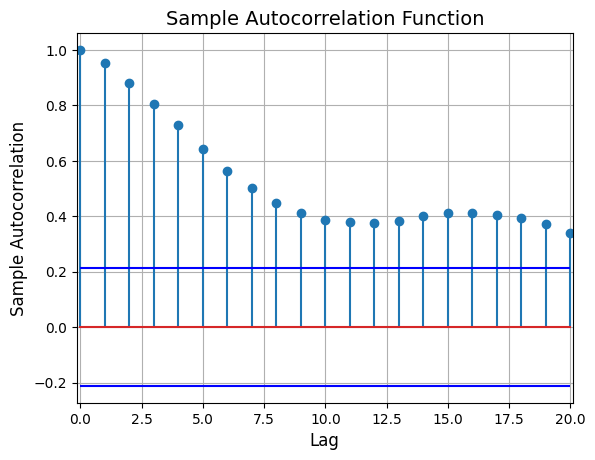

In [11]:
y = Y[4:,1] # CD91

corr, bound = bp.autocor(y)

출력된 이미지는 $h=0,...,20$이라는 시차 각각에 대한 표본 자기상관함수 (빨간점들)와 2 표준오차 이내의 신뢰구간 (파란선)을 나타낸다. 이때 모든 ACF들이 신뢰구간을 벗어나기 때문에 5\% 유의수준 하에서 변수가 백색잡음과정이라는 귀무가설이 기각된다고 해석할 수 있다.

그렇다면 만약 모든 ACF들이 신뢰구간 안에 포함된다면 해당 변수가 백색잡음과정이라고 결론을 내릴 수 있을까? 예를들어, 아래와 같이 전기 대비 실질GDP의 성장률을 동일한 귀무가설 하에서 검정한다면 다음과 같은 이미지가 출력된다.

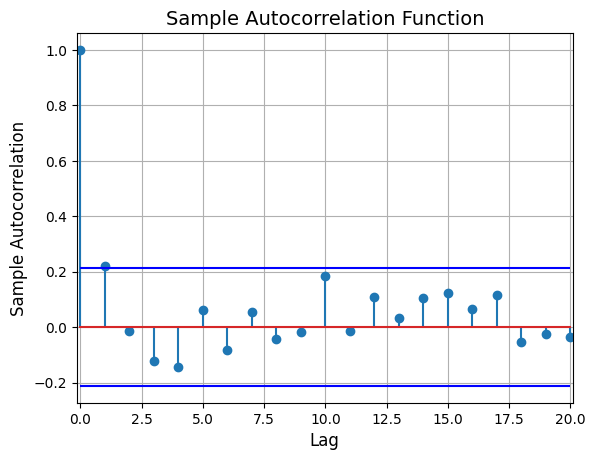

In [12]:
x = Y[4:,0]

corr1, bound1 = bp.autocor(x)

비록 $h=0$일때 ACF가 신뢰구간을 벗어나지만, 나머지 시차의 ACF들은 신뢰구간 안에 포함되어 전기 대비 실질 GDP 성장률이라는 변수가 백색잡음과정인 것처럼 보인다. 하지만 이는 잘못된 해석이다. 왜냐하면, 신뢰구간은 단순 가설검정의 결과로 이를 모든 시차에 대해서 반복하게 된다면 1종 오류 (귀무가설이 옳음에도 불구하고 검정통계량에 따라 귀무가설을 기각하는 판단을 내리는 것)의 가능성이 항상 존재하기 때문이다.

## 4. 백색잡음과정 결합 가설 검정 (Box-Pierce 검정 및 Ljung-Box 검정)
#### 구문
`bp` 패키지 속의 `WN_test`라는 함수를 사용하면 백색잡음과정에 대한 결합 가설 검정을 진행할 수 있다. 이때, `WN_test`라는 함수는 다음과 구성되어 있다.

> *<p style="font-size:20px">`BoxPierce, pval1, LjungBox, pval2 = bp.WN_test(X,taumax=None)`</p>*
> *<p style="font-size:15px">백색잡음과정 결합 가설 검정 (Box-Pierce와 Ljung-Box 검정)</p>*
> - **입력**:
</br></br>
    `X`: 추정하고자하는 변수 (단변수)
    </br></br>
    `taumax`: 추정에 사용하는 최대 시차 (default = 20)
    </br></br>
> - **출력**:
</br></br>
    `BoxPierce`: Box-Pierce 통계량 값
    </br></br>
    `pval1`: Box-Pierce 통계량의 p-값
    </br></br>
    `LjungBox`: Ljung-Box 통계량 값
    </br></br>
    `pval2`: Ljung-Box 통계량의 p-값
    </br></br>

#### 이론
위 단순 가설 검정으로 백색잡음과정을 검정하였을 때, 발생할 수 있는 문제로 인해 다음과 같이 결합 가설 검정을 통해 사용하는 변수가 백색잡음과정인지 검정을 시행해볼 수 있다. 이때 사용하는 검정통계량에 따라서 Box-Pierce 검정과 Ljung-Box 검정이라고 부른다.

우선 결합가설검정의 귀무가설과 대안가설은 다음과 같다.
$\begin{equation}
    \begin{cases}
        H_{0}\text{: }\rho(1)=\cdots=\rho(h)=0 \\
        H_{1}\text{: }\rho(s)\neq 0\text{ for some }1\leq s\leq h
    \end{cases} \tag{7}
\end{equation}$
나아가 **Box-Pierce 통계량**은
$\begin{equation}
    Q = T\cdot\sum_{\tau=1}^{h}{\hat{\rho}(\tau)^{2}} \tag{8}
\end{equation}$
이며, **Ljung-Box 통계량**은
$\begin{equation}
    Q = T\cdot(T+2)\cdot\sum_{\tau=1}^{h}{(T-\tau)^{-1}\cdot\hat{\rho}(\tau)^{2}} \tag{8}
\end{equation}$
과 같다.

#### 예시
다시 CD91일 금리 및 전기 대비 실질 GDP 성장률에 대해 위와 같은 결합가설검정을 진행하면 다음과 같은 결과를 얻을 수 있다.

In [13]:
BP_cd, pval_BP_cd, LB_cd, pval_LB_cd = bp.WN_test(y)

   Box-Pierce Stat (p-val)  Ljung-Box Stat (p-val)
0                  521.884                580.9286
1                    0.000                  0.0000
 
 H0:r(1)=r(2)=...r(h)=0; 백색잡음과정이다.
유의수준 < p-값 = 유의수준 하에서 귀무가설 (H0)을 기각, i.e. 백색잡음과정이 아니다.


In [14]:
BP_rgdp, pval_BP_rgdp, LB_rgdp, pval_LB_rgdp = bp.WN_test(x)

   Box-Pierce Stat (p-val)  Ljung-Box Stat (p-val)
0                  17.4763                 19.7040
1                   0.6219                  0.4766
 
 H0:r(1)=r(2)=...r(h)=0; 백색잡음과정이다.
유의수준 < p-값 = 유의수준 하에서 귀무가설 (H0)을 기각, i.e. 백색잡음과정이 아니다.


결과를 해석하면 우선 CD91일 금리에 대해서는 BP 검정이나 LB 검정 모두 p값이 0으로 나와 매우 보수적인 1\% 유의수준 하에서도 변수가 백색잡음이라는 귀무가설을 기각한다는 것을 알 수 있다. 반면 전년 대비 실질 GDP 성장률에 대해서는 BP 검정이나 LB 검정 모두 5\% 유의수준 하에서 변수가 백색잡음이라는 귀무가설을 기각하지 못하여 변수를 백색잡음으로 해석할 수 있다.

## 5. 자기회귀모형 (Autoregressive of lag p model, AR(p) model)

#### 구문
`bp` 패키지 속 `OLS_ARp` 함수를 사용한다면 위와 같은 AR(p) 자기회귀모형을 추정할 수 있다. 이때, `OLS_ARp` 함수는 다음과 같이 구성된다.

> *<p style="font-size:20px">`phi_hat, Omega_hat, F, Y0, y_lag, Y_predm = bp.OLS_ARp(y,p,printi=None,H=None)`</p>*
> *<p style="font-size:15px">AR(p) 모형에 대한 OLS 추정 결과</p>*
> - **입력**:
    </br></br>
    `y`: 추정하고자하는 변수 (단변수), T by 1 벡터
    </br></br>
    `p`: 추정하는 모형의 시차
    </br></br>
    `printi`: 추정 결과 출력 여부 (default = None)
    </br></br>
    `H`: 최대 예측 시차 (default = None)
    </br></br>
> - **출력**:
</br></br>
    `phi_hat`: OLS 계수 추정량, p by 1 벡터
    </br></br>
    `sig2_hat`: OLS 분산 추정량, 1 by 1 벡터
    </br></br>
    `F`: 동반행렬 (Companion Matrix) 형태의 계수 추정량
    </br></br>
    `Y0`: 추정에 사용된 반응변수, T-p by 1 벡터
    </br></br>
    `y_lag`: 추정에 사용된 설명변수, T-p by p 벡터
    </br></br>
    `Y_predm`: 예측된 값, H by 1 벡터
    </br></br>


#### 이론
시계열에서 단변수 확률과정을 다룰 경우, 설명변수가 $p$시차까지 반응변수의 회귀항들로 구성된 자기회귀모형을 가장 기본적으로 사용한다. 즉, 특정 확률과정 $y_{t}$의 모든 $t$기에 대한 AR(p) 모형은 아래와 같이 구성된다.
$\begin{equation}
    y_{t} = \alpha_{1}y_{t-1} + \cdots + \alpha_{p}y_{t-p} + e_{t}\text{, }e_{t}\sim WN(0,\sigma^{2}) \notag
\end{equation}$
이때, AR(p) 모형은 아래와 같은 특성이 있다.
* 인과-안정성 (causal-stationarity)

    AR(p)모형의 모든 계수항들의 절댓값이 1보다 작다면 해당 확률과정은 인과-안정적 과정 (causal-stationary process)이라고 한다. 한편, 계수항이 1에 가까울수록 확률과정은 이전 기들에 발생한 일이 현재 확률과정에게 중요한 persistent하다고 한다.

* 절편항

    위와 같은 AR(p)모형에는 절편항을 추가할 수 있다. 이때, $v$라는 절편항을 추가하는 것은 $y_{t}$라는 확률과정이 다음과 같은 기댓값을 가지고 있다는 것을 의미한다.
    $\begin{equation}
        \mathbb{E}(y_{t}) = \frac{v}{1-\alpha_{1}-\cdots-\alpha_{p}} \notag
    \end{equation}$
    대안적으로 절편항을 제외하는 대신 사용하는 반응변수의 데이터 $y_{t}$을 평균을 제거하여 사용하는 방법이 있다.

이때, `OLS_ARp` 코드에는 AR(p) 모형의 절편항을 고려하지 않기 위해 입력되는 `y` 변수에 대해 자동으로 demeaning 과정이 들어가 있다. 따라서, 예측 시 demeaning 과정에서 제거된 mean을 예측값에 더해주도록 코드가 작성되어 있다.



#### 예시
전년동기대비 인플레이션율에 대한 위와 같은 AR(p)모형을 추정해보자. 이때, 분기별 데이터를 사용하기 때문에 시차는 $p=4$, 예측은 하지 않기로 하자.

       Coefficients    S.E.  t-value  p-value
AR_L1        1.0832  0.1077  10.0581   0.0000
AR_L2       -0.0767  0.1529  -0.5016   0.6159
AR_L3       -0.1446  0.1547  -0.9347   0.3499
AR_L4       -0.0019  0.1064  -0.0178   0.9858
         Predicted Value for H = None is
H = None                             NaN


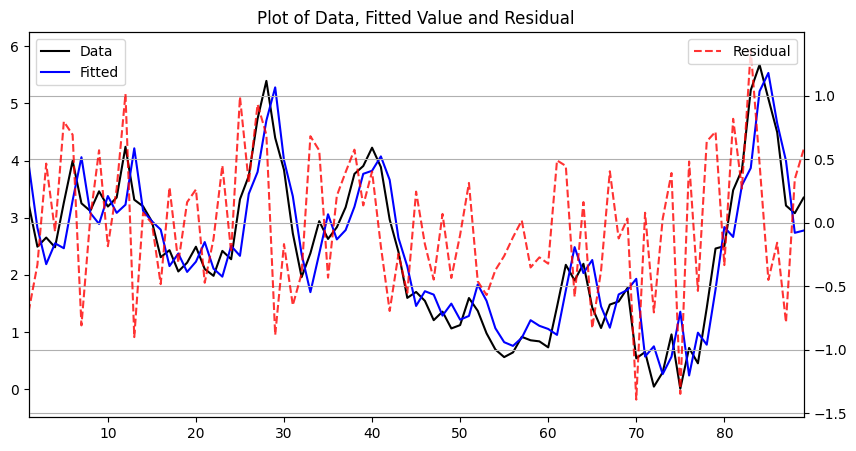

In [15]:
y = Y[:,2]
p = 4
printi = 1

phi_hat, sig2_hat, F, Y0, Y_lag, Y_predm = bp.OLS_ARp(y,p,printi)

만약 예측시차인 $H$를 설정한다면, AR(p)모형을 사용하여 해당 시계까지 동태적 예측법 (dynamic forecasting)으로 추정된 예측값들이 반환된다. 예를 들어, 다른 파라미터들은 이전과 같고, $H=4$일 때의 전년동기대비 인플레이션율에 대한 AR(p) 모형의 결과값은 다음과 같다.

       Coefficients    S.E.  t-value  p-value
AR_L1        1.0832  0.1077  10.0581   0.0000
AR_L2       -0.0767  0.1529  -0.5016   0.6159
AR_L3       -0.1446  0.1547  -0.9347   0.3499
AR_L4       -0.0019  0.1064  -0.0178   0.9858
     Predicted Value for H = 4 is
H=1                        3.2671
H=2                        3.0470
H=3                        2.6901
H=4                        2.3995


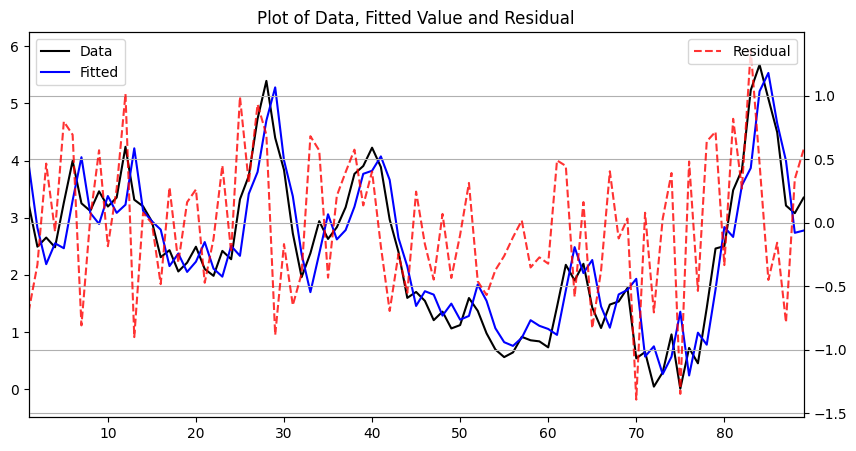

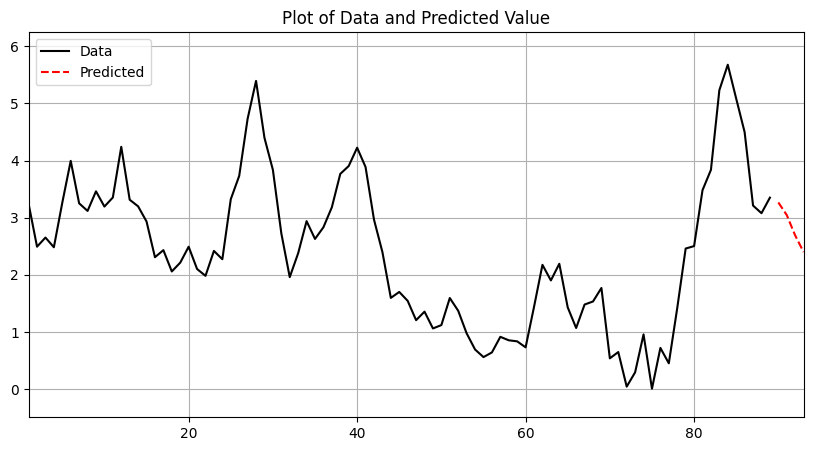

In [16]:
H = 4

phi_hat, sig2_hat, F, Y0, Y_lag, Y_predm = bp.OLS_ARp(y,p,printi,H)

추정 결과, 전년동기대비 인플레이션율에 대한 향후 4기 동안의 예측값은 1기 이후 약 3.27\%에서 4기 이후 약 2.40\%까지 점진적으로 감소하는 것으로 나타났다.